In [1]:
import sys
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

sys.path.append('/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/code')
import nibabel as nib
from dn_utils.behavioral_models import load_behavioral_data                          
from bids import BIDSLayout
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, show
from nistats.first_level_model import FirstLevelModel
from nistats.reporting import plot_design_matrix
from nistats.thresholding import map_threshold
from nistats.design_matrix import make_first_level_design_matrix
from functools import reduce

/home/kmb/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


### Load task onsets

Load behavioral data containg relevant task onsets. 

In [2]:
beh_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/" \
          "data/main_fmri_study/sourcedata/behavioral"
beh, meta = load_behavioral_data(root=beh_dir)
n_subjects, n_conditions, n_trials, _ = beh.shape

Shape of beh array: (32, 2, 110, 21)
Conditions [(0, 'rew'), (1, 'pun')]
Columns: [(0, 'block'), (1, 'rwd'), (2, 'magn_left'), (3, 'magn_right'), (4, 'response'), (5, 'rt'), (6, 'won_bool'), (7, 'won_magn'), (8, 'acc_after_trial'), (9, 'onset_iti'), (10, 'onset_iti_plan'), (11, 'onset_iti_glob'), (12, 'onset_dec'), (13, 'onset_dec_plan'), (14, 'onset_dec_glob'), (15, 'onset_isi'), (16, 'onset_isi_plan'), (17, 'onset_isi_glob'), (18, 'onset_out'), (19, 'onset_out_plan'), (20, 'onset_out_glob')]


### Query neuroimaging dataset (path extraction)

Using BIDSLayout object query BIDS dataset to pull out necessary files.
- `anat_files`: sorted list of preprocessed T1w images
- `fmri_files`: list of two lists containing sorted (by subject number) paths to imaging files, first list corresponds to reward condition of PRL task and second list corresponds to punishment condition of PRL task
- `conf_files`: list of two lists containing sorted (by subject number) paths to confound files
- `mask_files`: brain mask files for fmri sequencnes

In [3]:
bids_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/main_fmri_study"

layout = BIDSLayout(
    root=bids_dir,
    derivatives=True,
    validate=True,
    index_metadata=False
)

anat_filter = {
    "extension": [".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "suffix": "T1w",
    "desc": "preproc",
    "return_type": "filename"
}

fmri_filter = {
    "extension": [".nii", ".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "suffix": "bold",
    "desc": "preproc",
    "return_type": "filename"
}

conf_filter = {
    "extension": "tsv",
    "desc": "confounds",
    "return_type": "filename"
}

mask_filter = {
    "extension": [".nii.gz"],
    "space": "MNI152NLin2009cAsym",
    "desc": "brain",
    "suffix": "mask",
    "return_type": "filename"
}

anat_files = layout.get(**anat_filter)

fmri_files, conf_files, mask_files = [], [], []

for task_dict in [{"task": "prlrew"}, {"task": "prlpun"}]:
    fmri_filter.update(task_dict)
    conf_filter.update(task_dict)
    mask_filter.update(task_dict)
    fmri_files.append(layout.get(**fmri_filter))
    conf_files.append(layout.get(**conf_filter))
    mask_files.append(layout.get(**mask_filter))

### Single subject analysis

Here, first level GLM analysis is performed for each subject. For each imaging sequence following steps are applied:
1. relevant files are loaded: anatomical, functional, brain mask for functional file
2. `confounds` dataframe is loaded and filtered. Included confounds are: six motion parameters and first five a_comp_cor regressors
4. glm model is evaluated (beta estimates for all regressors)
5. ...

### Approach 1
Regressors of interest:
- +PE regressor (1 for correct answer and 0 for incorrect)
- -PE regressor (1 for incorrect answer and 0 for correct)

Regressors of no interest:
- missPE regressor (1 for trials where there was no answer)
- confounds

Contrast:
- +PE minus -PE

In [ ]:
out_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/"\
          "main_fmri_study/derivatives/nistats/pesign_separate"

# Specify GLM
fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model='ar1',
    drift_model='cosine',
    period_cut=128,
    standardize=False,
    hrf_model='spm',
    smoothing_fwhm=6)

In [ ]:
# Separate regressors for +PE and -PE
for sub_idx in range(n_subjects):

    print(f"Analyzing sub-{meta['dim1'][sub_idx]}...")
    
    for con_idx in range(n_conditions):

        # Load imaging data
        anat_img = nib.load(anat_files[sub_idx])
        fmri_img = nib.load(fmri_files[con_idx][sub_idx])
        fmri_glm.mask = nib.load(mask_files[con_idx][sub_idx])

        # Create single subject regressors
        out_onset = beh[sub_idx, con_idx, :, meta['dim4'].index('onset_out')]
        out_duration = np.zeros(n_trials)

        resp_type = beh[sub_idx, con_idx, :, meta['dim4'].index('response')]
        won_bool = beh[sub_idx, con_idx, :, meta['dim4'].index('won_bool')]
        pe_type = (resp_type != 0) * ((won_bool - .5) * 2)

        events_array = np.hstack((out_onset[:, np.newaxis],
                                  out_duration[:, np.newaxis],
                                  pe_type[:, np.newaxis]))

        events = pd.DataFrame(events_array, columns=['onset', 'duration', 'trial_type'])
        events.loc[events.trial_type ==  1, "trial_type"] = 'pe_sgn_pos'
        events.loc[events.trial_type == -1, "trial_type"] = 'pe_sgn_neg'
        events.loc[events.trial_type ==  0, "trial_type"] = 'pe_miss'

        # Grab and filter confounds
        confounds_relevant = ['a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 
                              'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05', 
                              'trans_x', 'trans_y', 'trans_z', 
                              'rot_x', 'rot_y', 'rot_z']

        confounds = pd.read_csv(conf_files[con_idx][sub_idx], sep='\t')
        confounds = confounds[confounds_relevant]

        # Fit GLM
        fmri_glm = fmri_glm.fit(
            fmri_img,
            events=events,
            confounds=confounds);

        # Define contrast
        design_matrix = fmri_glm.design_matrices_[0]
        conditions = {
            'pe_sgn_pos': np.zeros(design_matrix.shape[1]),
            'pe_sgn_neg': np.zeros(design_matrix.shape[1]),
        }
        conditions['pe_sgn_pos'][list(design_matrix.columns).index('pe_sgn_pos')] = 1
        conditions['pe_sgn_neg'][list(design_matrix.columns).index('pe_sgn_neg')] = 1
        pos_minus_neg = conditions['pe_sgn_pos'] - conditions['pe_sgn_neg']

        # Compute statistical map and save it
        z_map = fmri_glm.compute_contrast(
            pos_minus_neg,
            stat_type='t')

        z_map_fname = f"sub-{meta['dim1'][sub_idx]}_task-prl{meta['dim2'][con_idx]}_desc-pesign_tmap"
        nib.save(z_map, os.path.join(out_dir, z_map_fname))

### Approach 2
Regressors of interest:
- parametrically modulated PE sign regressor (1 for correct answer and -1 for incorrect)

Regressors of no interest:
- missPE regressor (1 for trials where there was no answer)
- confounds

Contrast:
- main effect of modulated PE sign regressor

In [10]:
out_dir = "/home/kmb/Desktop/Neuroscience/Projects/BONNA_decide_net/data/"\
          "main_fmri_study/derivatives/nistats/pesign_modulated"

# Specify GLM
fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model='ar1',
    drift_model='cosine',
    period_cut=128,
    standardize=False,
    hrf_model='spm',
    smoothing_fwhm=6)

In [11]:
# Single modulated PE regressor
for sub_idx in range(n_subjects):

    print(f"Analyzing sub-{meta['dim1'][sub_idx]}...")
    
    for con_idx in range(n_conditions):

        # Load imaging data
        anat_img = nib.load(anat_files[sub_idx])
        fmri_img = nib.load(fmri_files[con_idx][sub_idx])
        fmri_glm.mask = nib.load(mask_files[con_idx][sub_idx])

        # This is done throught manual creation of design matrix using 
        # make_design_matrix function from nistats. Additional data is needed, since 
        # number of scans cannot be inferred automatically.
        n_scans = 730
        t_r = 2
        frame_times = np.arange(n_scans) * t_r

        # Get subject data
        out_onset = beh[sub_idx, con_idx, :, meta['dim4'].index('onset_out')]
        out_duration = np.zeros(n_trials)
        resp_type = beh[sub_idx, con_idx, :, meta['dim4'].index('response')]
        won_bool = beh[sub_idx, con_idx, :, meta['dim4'].index('won_bool')]

        # Create parametrically modulated regressor
        # Grab only outcome events for trials without missing response 
        events_mod_array = np.hstack((out_onset[resp_type != 0][:, np.newaxis],
                                      out_duration[resp_type != 0][:, np.newaxis],
                                      np.ones(np.sum(resp_type != 0))[:, np.newaxis],
                                      (won_bool[resp_type != 0][:, np.newaxis] - .5) * 2))
        events_mod = pd.DataFrame(events_mod_array,
                                  columns=['onset', 'duration', 'trial_type', 'modulation'])
        events_mod.loc[events_mod.trial_type ==  1, "trial_type"] = 'pe_sgn_mod'
        events_mod['modulation'] -= events_mod['modulation'].mean()

        dm_mod = make_first_level_design_matrix(
            frame_times,
            events_mod,
            drift_model=None
        )

        # Grab and filter confounds
        confounds_relevant = ['a_comp_cor_00', 'a_comp_cor_01', 'a_comp_cor_02', 
                              'a_comp_cor_03', 'a_comp_cor_04', 'a_comp_cor_05', 
                              'trans_x', 'trans_y', 'trans_z', 
                              'rot_x', 'rot_y', 'rot_z']

        confounds = pd.read_csv(conf_files[con_idx][sub_idx], sep='\t')
        confounds = confounds[confounds_relevant]

        # Create design matrix without parametrically modulated regressors
        events_array = np.hstack((out_onset[resp_type == 0][:, np.newaxis],
                                  out_duration[resp_type == 0][:, np.newaxis],
                                  np.ones(np.sum(resp_type == 0))[:, np.newaxis]))
        events = pd.DataFrame(events_array, columns=['onset', 'duration', 'trial_type'])
        events.loc[events.trial_type ==  1, "trial_type"] = 'pe_miss'

        # Concatenate modulated regressors and confounds
        add_regs = np.hstack((dm_mod['pe_sgn_mod'][:, np.newaxis], np.array(confounds)))
        add_reg_names = ['pe_sgn_mod'] + list(confounds.columns)

        # Create final design matrix
        dm_final = make_first_level_design_matrix(
            frame_times,
            events,
            add_regs=add_regs,
            add_reg_names=add_reg_names
        )

        # Fit GLM
        fmri_glm = fmri_glm.fit(
            fmri_img,
            design_matrices=dm_final
        )

        # Define contrast
        design_matrix = fmri_glm.design_matrices_[0]
        conditions = {
            'pe_sgn_mod': np.zeros(design_matrix.shape[1]),
        }
        conditions['pe_sgn_mod'][list(design_matrix.columns).index('pe_sgn_mod')] = 1

        # Compute statistical map and save it
        z_map = fmri_glm.compute_contrast(
            conditions['pe_sgn_mod'],
            stat_type='t')

        z_map_fname = f"sub-{meta['dim1'][sub_idx]}_task-prl{meta['dim2'][con_idx]}_desc-pesign_tmap"
        nib.save(z_map, os.path.join(out_dir, z_map_fname))

Analyzing sub-m02...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m03...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m04...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m05...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m06...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m07...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m08...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m09...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m10...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m11...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m12...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m13...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m14...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m15...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m16...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m17...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m18...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m19...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m20...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m21...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m22...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m23...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m24...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m25...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m26...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m27...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m28...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m29...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m30...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m31...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m32...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

Analyzing sub-m33...


/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
<string>:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None
/home/kmb/.local/lib/python3.6/site-packages/nistats/experimental_paradigm.py:63: UserWarning: 'modulation' column found in the given events data.
  warnings.warn("'modulation' column found in the given events data.")
<string>:6: Depreca

### Show example statistical map

/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/_utils/niimg.py:157: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance(niimgs, collections.Iterable):
/home/kmb/anaconda3/lib/python3.7/site-packages/nilearn/plotting/displays.py:1565: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if (not isinstance(cut_coords, collections.Sequence) and
/home/kmb/anaconda3/lib/python3.7/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


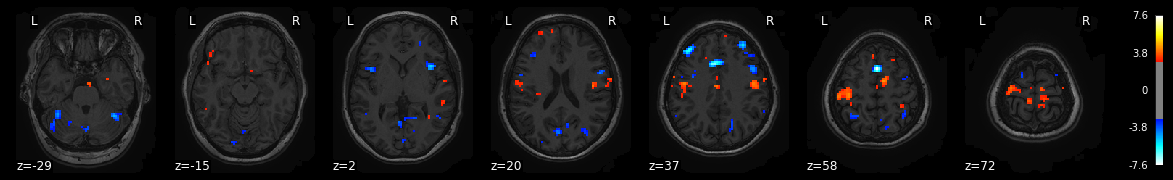

In [9]:
# (optional) Display first-level results in the brain space
_, threshold = map_threshold(
    z_map, 
    level=.05, 
    height_control='fpr')

plot_stat_map(
    z_map, 
    bg_img=anat_img,
    threshold=3,
    display_mode='z')